# 투빅스 15기 정규세션 10주차 DCGAN 구현 과제
"빈칸" 부분을 채우는 과제입니다. "빈칸"뿐만 아니라 중간중간 주석 또는 마크다운으로 설명 부탁드립니다  
https://github.com/pytorch/tutorials/blob/master/beginner_source/dcgan_faces_tutorial.py  
위의 주소는 pytorch dcgan 공식 튜토리얼 코드로 해당 코드를 바탕으로 과제를 만들었습니다. 튜토리얼 코드와 과제 코드가 상당부분 유사하므로 어려운 점이 있을 때 참고하면 좋을 것 같습니다  
다만, 그대로 복붙이 아닌 코드를 이해해 나가면서 과제를 수행해주시기 바랍니다  
마지막 과제인 만큼 다들 화이팅!

## 드라이브 연결

In [ ]:
# gdrive에 mount
from google.colab import drive
drive.mount('/content/gdrive')
# 경로 설정
import os
os.chdir('/content/gdrive/My Drive/')

Mounted at /content/gdrive


## 패키지 임포트

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms

## MNIST 데이터 불러오기
기존의 MNIST 손글씨 데이터의 경우 1x28x28 이미지 -> dcgan 모델 적용을 위해 1x64x64 이미지로 크기 조절 (물론 28x28이미지도 사용가능하지만 네트워크 구조 수정 필요)  
처음 데이터를 사용할때는 download=True로 데이터를 다운 받기  
이후에 사용할때는 데이터가 이미 다운되있으므로 download=False로 바꿔서 사용

In [ ]:
# MNIST dataset
dataroot = './mnist_data/'
imageSize = 64 # the height / width of the input image to network

dataset = dset.MNIST(root = dataroot, download= False,
                     transform = transforms.Compose([
                                                     transforms.Resize(imageSize), #이미지 64x64로 크기 변환
                                                     transforms.ToTensor(), #텐서자료형으로 변환
                                                     transforms.Normalize((0.5,), (0.5,)), #노말라이즈를 통해 -1.~1.의 값을 갖게 변환
                     ]))

### 데이터 확인하기

In [ ]:
print('number of training data: ', len(dataset)) #데이터 수 확인
image,_ = dataset[0]

print('Image')
print('========================================')
print('shape of this image\t:', image.shape) #데이터 차원(모양)확인하기

number of training data:  60000
Image
shape of this image	: torch.Size([1, 64, 64])


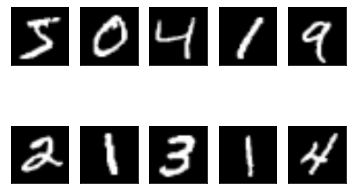

In [ ]:
# 학습 데이터 시각화
fig = plt.figure()

for i in range(10):
    image,_ = dataset[i]
    image = (image+1)/2
    image = image.squeeze()
    np_img = image.numpy()
    
    subplot = fig.add_subplot(2, 5, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(np_img, cmap = 'gray')

plt.show()

### 데이터 로더 정의

In [ ]:
# dataloader
batch_size = 128
workers = 2

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle = True, num_workers = workers)

## device 정의

In [ ]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 신경망 

In [ ]:
#네트워크 하이퍼파라미터 설정
nc = 1 # number of channels in the training images
nz = 100 # size of z latent vector
ngf = 64 # size of feature maps in generator
ndf = 64 # size of feature maps in discriminator

### 신경망 가중치 초기화 함수 정의
신경망의 가중치 초기화 방법에 대해 논문에 자세히 나와있습니다.  
다음 사이트는 파이토치에서 가중치 초기화에 관련된 글 입니다  
https://www.javaer101.com/ko/article/1010427.html

In [ ]:
# 논문에 따르면 모든 가중치들은 평균이 0이고, 표준편차가 0.02인 정규분포로 초기화시킴
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### 생성자 클래스

trasposed convolution 관련 자료: https://yonghyuc.wordpress.com/2019/08/08/transposed-convolutions-aka-deconvolution/

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    # pooling대신 fractional-strided convolution을 사용하여 사이즈를 키워줌
    # batchnorm을 사용하기 때문에 conv내부의 bias는 학습하지 않음
    # Generator에서는 relu activation을 사용함
    self.main = nn.Sequential(
        # noise z를 (n_batch, 100, 1, 1)의 형태로 입력받기 때문에 fclayer와 reshape과정이 필요 없음
        nn.ConvTranspose2d(in_channels = nz,
                           out_channels = ngf * 8,
                           kernel_size = 4,
                           stride = 1,
                           padding = 0,
                           bias = False),
        nn.BatchNorm2d(num_features = ngf * 8),
        nn.ReLU(inplace = True),
        # output_shape : (512, 4, 4)
        # convtranspose를 사용해 100차원의 noise를 (1024, 4, 4)의 영상으로 만들어줌
        nn.ConvTranspose2d(in_channels = ngf * 8,
                           out_channels = ngf * 4,
                           kernel_size = 4,
                           stride = 2,
                           padding = 1,
                           bias = False),
        nn.BatchNorm2d(num_features = ngf * 4),
        nn.ReLU(inplace = True),
        # output_shape : (256, 8, 8)

        nn.ConvTranspose2d(in_channels = ngf * 4,
                           out_channels = ngf * 2,
                           kernel_size = 4,
                           stride = 2,
                           padding = 1,
                           bias = False),
        nn.BatchNorm2d(num_features = ngf * 2),
        nn.ReLU(inplace = True),
        # output_shape : (128, 16, 16)

        nn.ConvTranspose2d(in_channels = ngf * 2,
                           out_channels = ngf * 1,
                           kernel_size = 4,
                           stride = 2,
                           padding = 1,
                           bias = False),
        nn.BatchNorm2d(num_features = ngf * 1),
        nn.ReLU(inplace = True),
        # output_shape : (64, 32, 32)

        nn.ConvTranspose2d(in_channels = ngf * 1,
                           out_channels = nc,
                           kernel_size = 4,
                           stride = 2,
                           padding = 1,
                           bias = False),
        nn.Tanh()
        # output_shape : (1, 64, 64)
    )
                                
  def forward(self, input):
    return self.main(input)

In [ ]:
netG = Generator().to(device) # 생성자 객체 생성
netG.apply(weights_init) # 위의 정의한 함수로 가중치 초기화


# 생성자 출력
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### 판별자 클래스

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    # pooling을 사용하는 대신 convolution의 stride를 통해 영상의 사이즈를 키워줌
    # batchnorm을 사용하기 때문에 conv내부의 bias는 학습하지 않음
    # Discriminator서는 LeakyReLU activation으로 사용하되, slope of leak는 0.2로 설정
    # DCGAN 논문에 따로 명시된 Discriminator의 구조가 없으므로 Generator의 역으로 함
    self.main = nn.Sequential(
        nn.Conv2d(in_channels = nc,
                  out_channels = ndf * 1,
                  kernel_size = 4,
                  stride = 2,
                  padding = 1,
                  bias = False),
        nn.LeakyReLU(negative_slope = 0.2, inplace = True),
        # output_shape : (64, 32, 32)

        nn.Conv2d(in_channels = ndf,
                  out_channels = ndf * 2,
                  kernel_size = 4,
                  stride = 2,
                  padding = 1,
                  bias = False),
        nn.BatchNorm2d(num_features = ndf * 2),
        nn.LeakyReLU(negative_slope = 0.2, inplace = True),
        # output_shape : (128, 16, 16)

        nn.Conv2d(in_channels = ndf * 2,
                  out_channels = ndf * 4,
                  kernel_size = 4,
                  stride = 2,
                  padding = 1,
                  bias = False),
        nn.BatchNorm2d(num_features = ndf * 4),
        nn.LeakyReLU(negative_slope = 0.2, inplace = True),
        # output_shape : (256, 8, 8)

        nn.Conv2d(in_channels = ndf * 4,
                  out_channels = ndf * 8,
                  kernel_size = 4,
                  stride = 2,
                  padding = 1,
                  bias = False),
        nn.BatchNorm2d(num_features = ndf * 8),
        nn.LeakyReLU(negative_slope = 0.2, inplace = True),
        # output_shape : (512, 4, 4)

        nn.Conv2d(in_channels = ndf * 8,
                  out_channels = 1,
                  kernel_size = 4,
                  stride = 2,
                  padding = 0,
                  bias = False),
        nn.Sigmoid()
        # output_shape : (1, 1, 1)
    )

  def forward(self, input):
    return self.main(input)

In [ ]:
netD = Discriminator().to(device) # 생성자 객체 생성
netD.apply(weights_init) # 위의 정의한 함수로 가중치 초기화

# 판별자 출력
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (12): Sigmoid()
  )
)


## Loss Function & Optimizer

In [ ]:
# 손실함수
# DCGAN역시 목적함수가 GAN과 동일하기 때문에 BCELoss로 목적함수 모델링 가능하다.
criterion = nn.BCELoss()

real_label = 1.
fake_label = 0.


# optimizer hyperparameters
# 논문에 따르면 Adam optimizer를 사용하고
# learning rate 0.001이 너무 높기 때문에 0.0002를 사용
# beta1 0.9를 사용하면 훈련진동과 불안정성 초래하므로 0.5 사용
learning_rate = 0.0002
beta1 = 0.5

# optimizers
optimizerD = optim.Adam(netD.parameters(), lr = learning_rate, betas = (beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = learning_rate, betas = (beta1, 0.999))

## Train
"빈칸"을 채우고, 각각의 변수 및 메소드가 무엇을 나태는지 혹은 어떻게 계산되는지를 주석으로 설명 부탁드립니다.  
참고하면 좋은 사이트: https://redstarhong.tistory.com/64

In [ ]:
num_epochs = 5
D_loss = []
G_loss = []

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        netD.zero_grad() # 기울기 초기화
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype = torch.float, device = device)
        # Discriminator학습을 위한 label을 만들어준다.
        # real_label 1을 128차원의 tensor로 확장한다.
        output = netD(real_cpu).view(-1) # Discriminator의 판별
        errD_real = criterion(output, label)
        # Disc의 output을 통해 loss를 계산
        # x가 실제 이미지일 경우 logD(x)의 최대화
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device) # (n_batch, 100, 1, 1)의 형태로 noise를 생성
        fake = netG(noise)
        label.fill_(fake_label) # label에 0을 채워줌
        output = netD(fake.detach()).view(-1) 
        # 현재 Disc를 학습중이므로, Generator의 computation graph를 보존하기 위해 fake image에 대한 판별을 detach
        errD_fake = criterion(output, label) 
        # Disc의 output을 통해 loss를 계산
        # 가짜 이미지일 경우 log(1-D(G(z)))의 최대화
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake # 진짜 이미지와 가짜 이미지를 입력으로 했을경우의 loss를 더해줌
        optimizerD.step()
        D_loss.append(errD)


        netG.zero_grad() # 기울기 초기화
        label.fill_(real_label) # label에 1을 채워줌
        output = netD(fake).view(-1) # 아까 생성한 fake image를 forward pass
        errG = criterion(output, label) 
        # 생성자의 입장에서 log(1-D(G(z)))를 최소화
        errG.backward()
        D_G_z2 = output.mean().item()
        G_loss.append(errG)

        optimizerG.step()

        # 학습 경과 출력
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
            % (epoch, num_epochs, i, len(dataloader),
                errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

[0/5][0/469]	Loss_D: 1.2653	Loss_G: 4.1511	D(x): 0.5677	D(G(z)): 0.4111 / 0.0224
[0/5][50/469]	Loss_D: 0.7008	Loss_G: 18.7668	D(x): 0.9818	D(G(z)): 0.4172 / 0.0000
[0/5][100/469]	Loss_D: 0.0506	Loss_G: 4.9940	D(x): 0.9625	D(G(z)): 0.0077 / 0.0122
[0/5][150/469]	Loss_D: 0.0395	Loss_G: 4.2624	D(x): 0.9842	D(G(z)): 0.0207 / 0.0755
[0/5][200/469]	Loss_D: 0.1367	Loss_G: 3.8066	D(x): 0.9246	D(G(z)): 0.0404 / 0.0318
[0/5][250/469]	Loss_D: 0.1881	Loss_G: 3.7402	D(x): 0.9190	D(G(z)): 0.0873 / 0.0363
[0/5][300/469]	Loss_D: 0.1831	Loss_G: 3.2689	D(x): 0.8690	D(G(z)): 0.0224 / 0.0521
[0/5][350/469]	Loss_D: 0.2332	Loss_G: 3.2048	D(x): 0.8996	D(G(z)): 0.1088 / 0.0582
[0/5][400/469]	Loss_D: 0.1637	Loss_G: 3.5433	D(x): 0.9239	D(G(z)): 0.0740 / 0.0447
[0/5][450/469]	Loss_D: 0.5562	Loss_G: 2.0756	D(x): 0.7703	D(G(z)): 0.2136 / 0.1570
[1/5][0/469]	Loss_D: 0.5388	Loss_G: 3.2552	D(x): 0.9301	D(G(z)): 0.3394 / 0.0532
[1/5][50/469]	Loss_D: 0.4236	Loss_G: 1.7190	D(x): 0.7061	D(G(z)): 0.0235 / 0.2150
[1/5][100

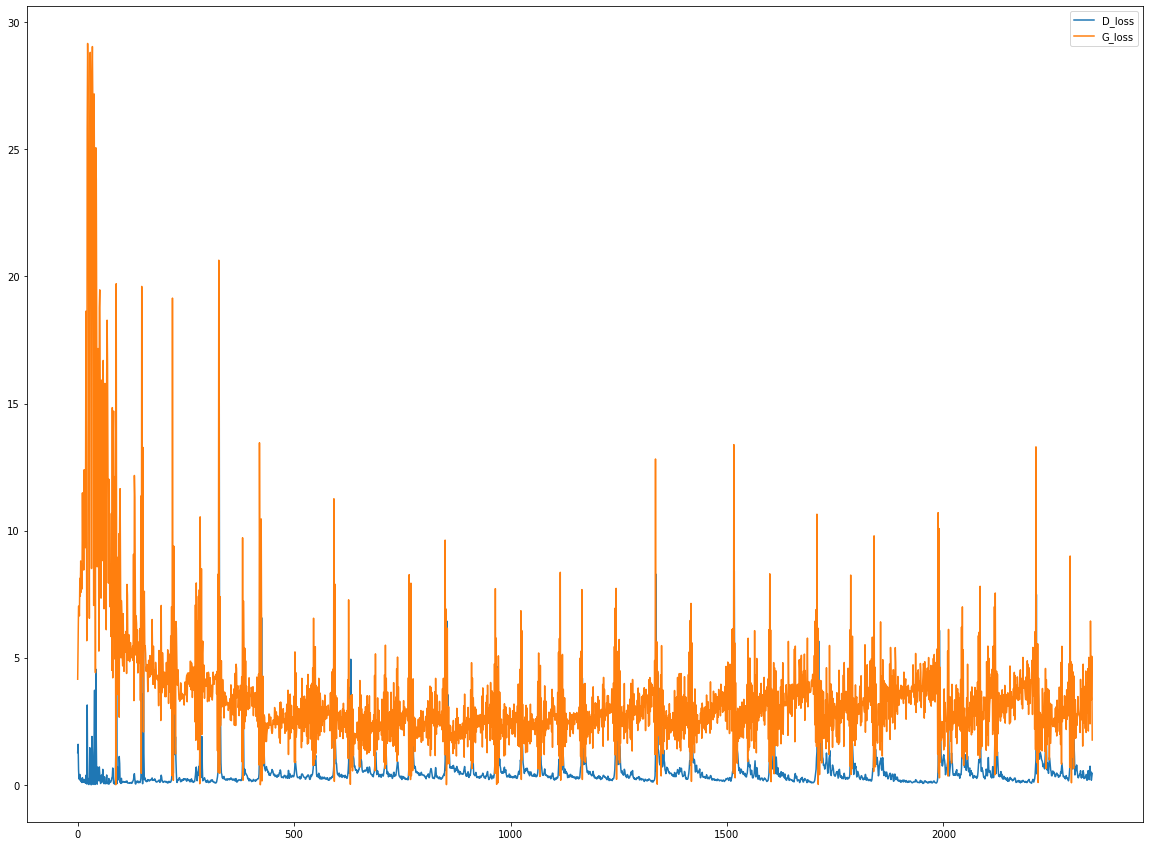

In [ ]:
plt.figure(figsize = (20, 15))
plt.plot(D_loss, label = "D_loss")
plt.plot(G_loss, label = "G_loss")
plt.legend()

In [ ]:
noise = torch.randn(batch_size, nz, 1, 1, device=device)
generated_img = netG(noise)

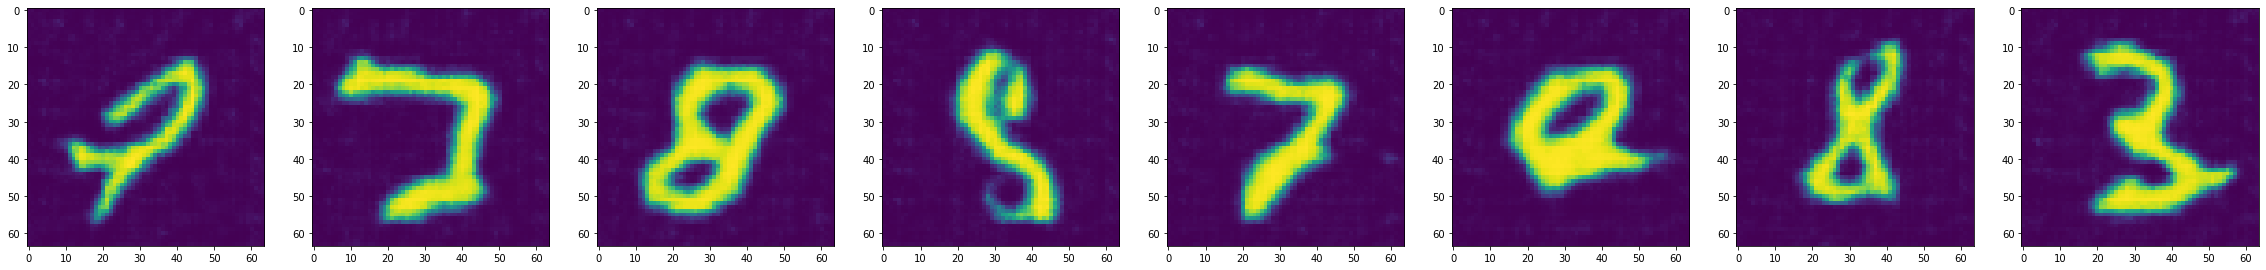

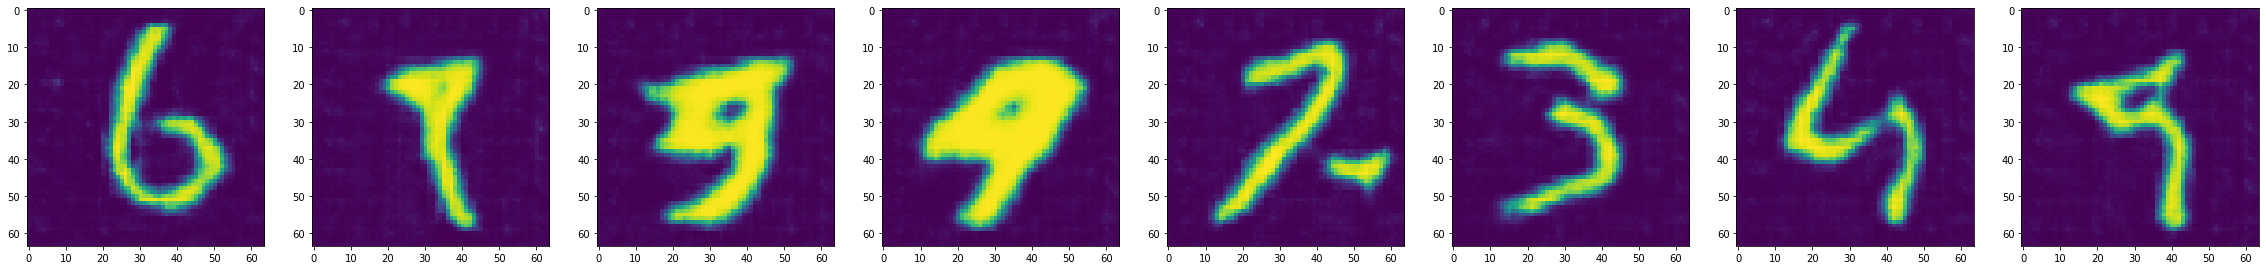

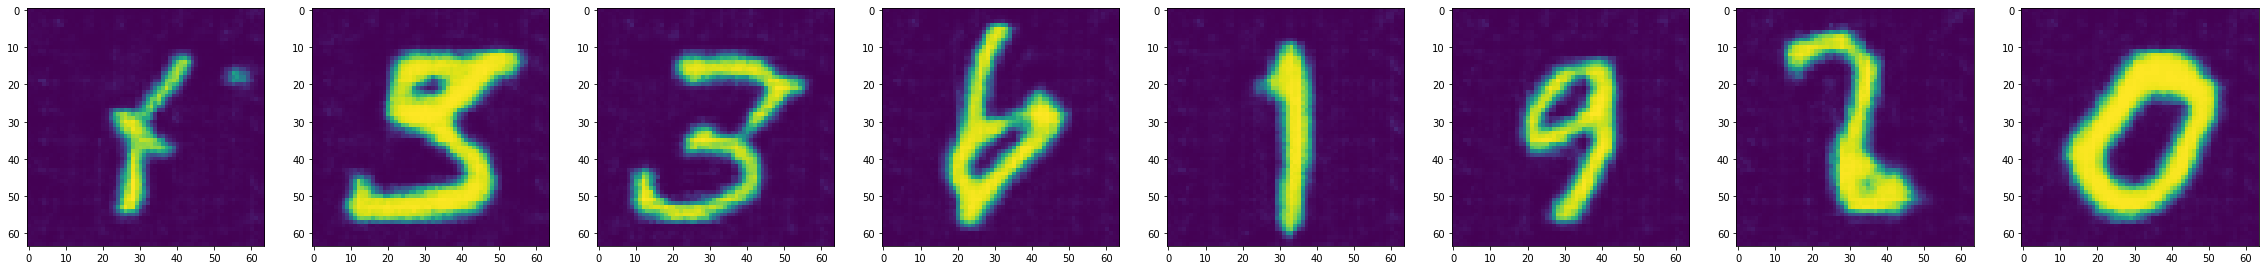

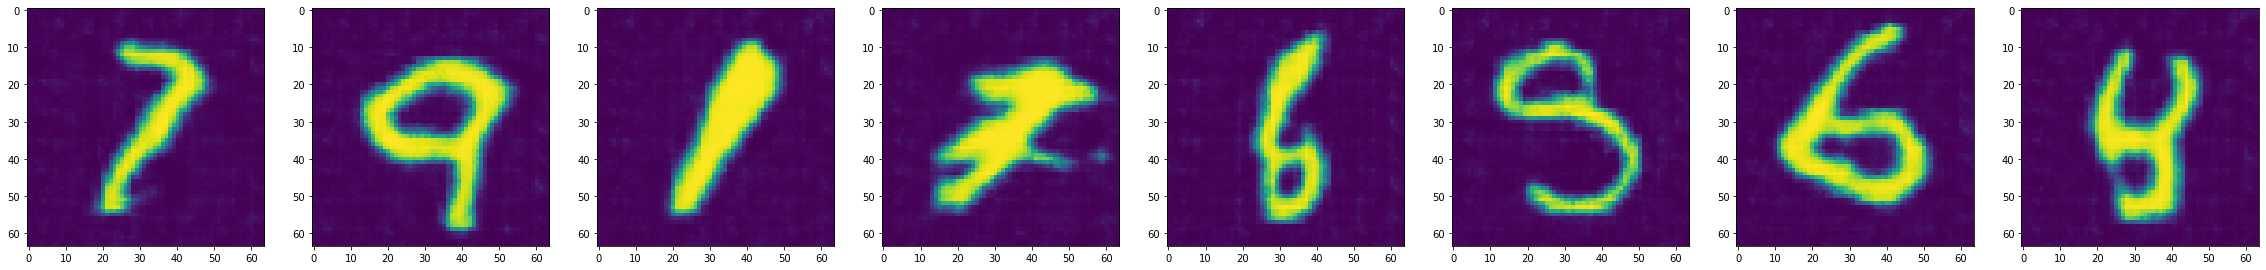

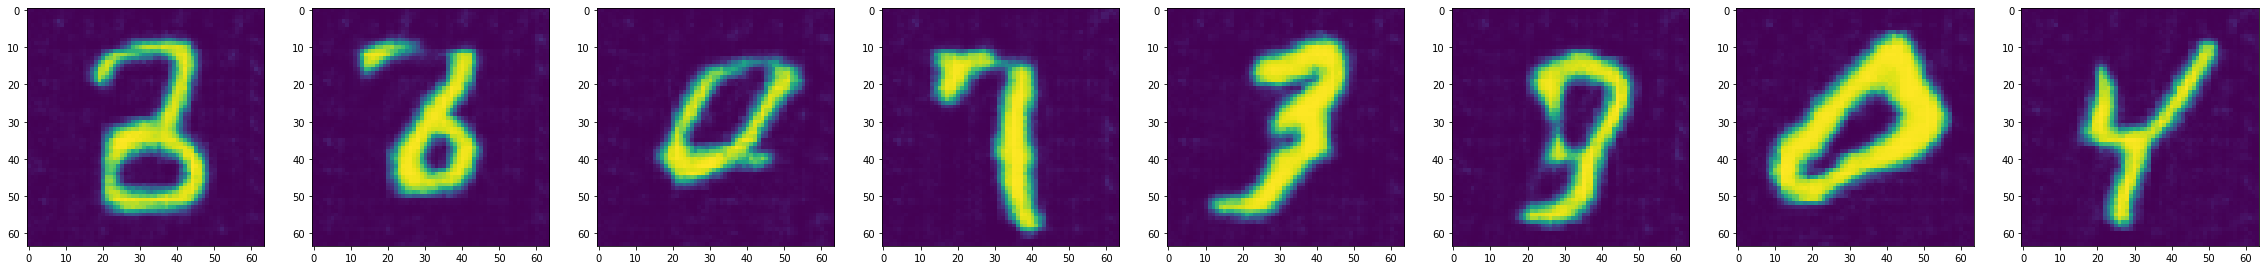

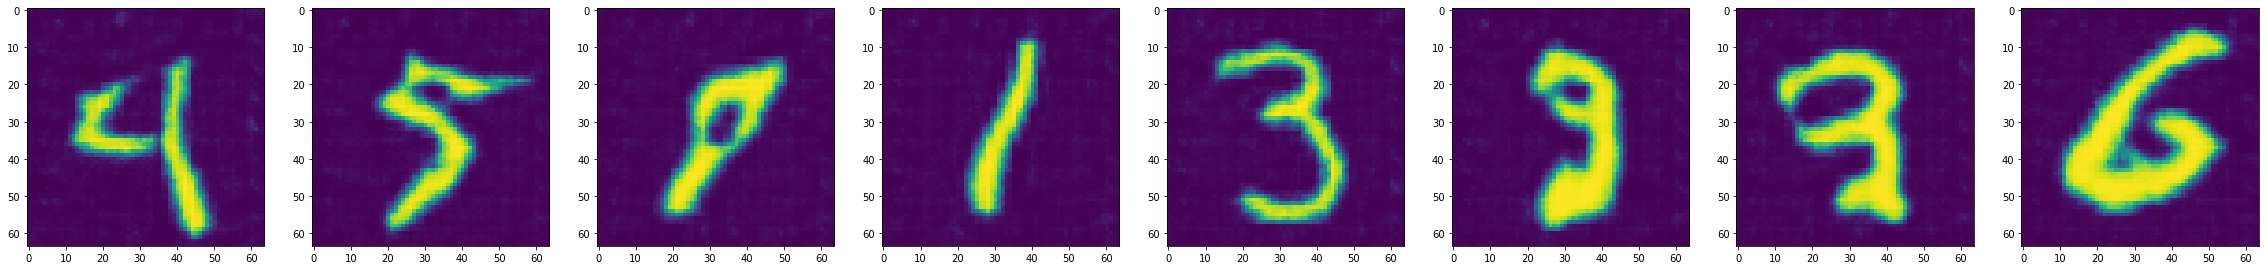

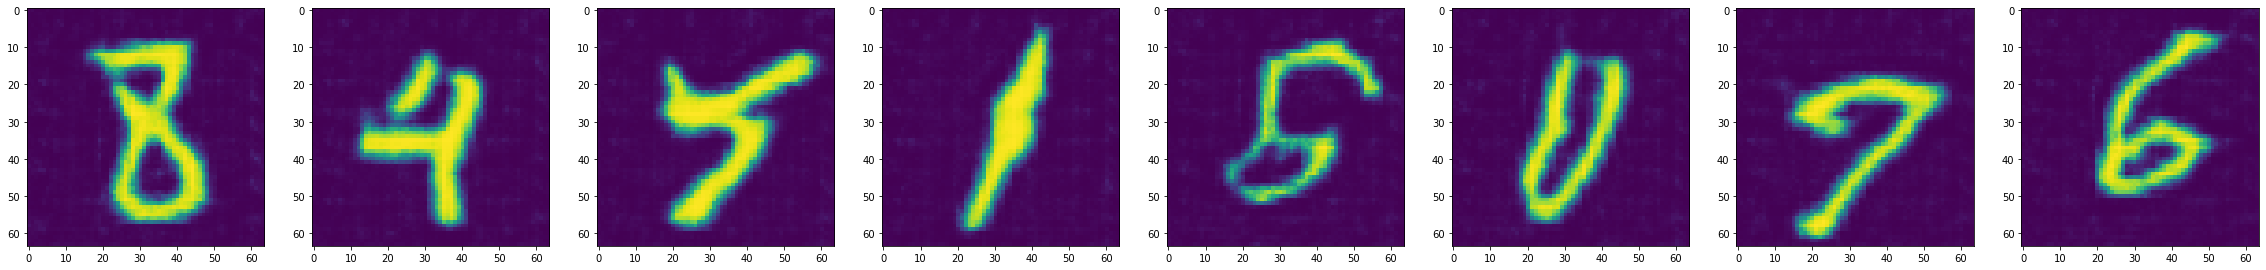

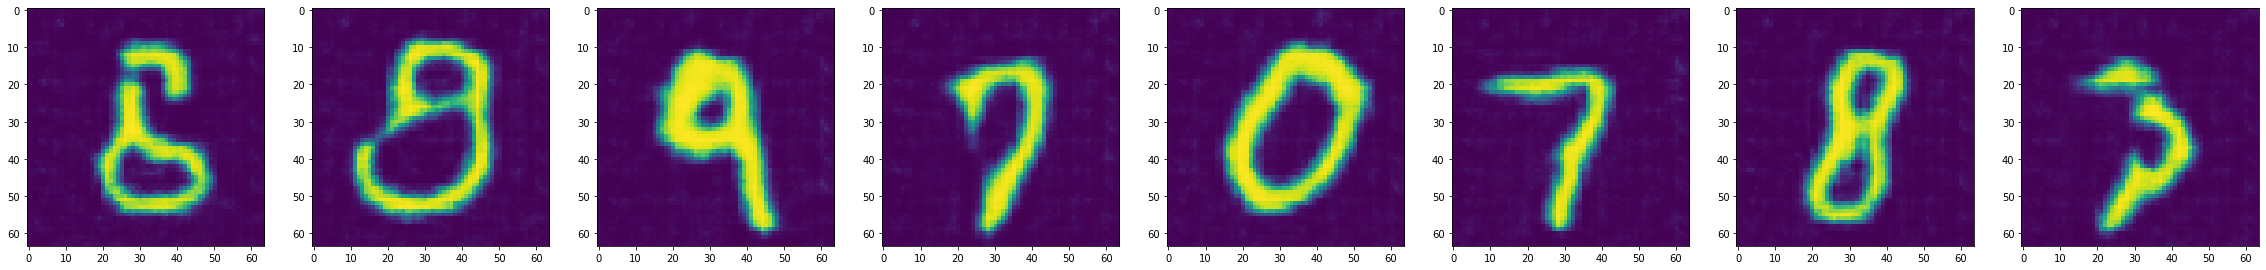

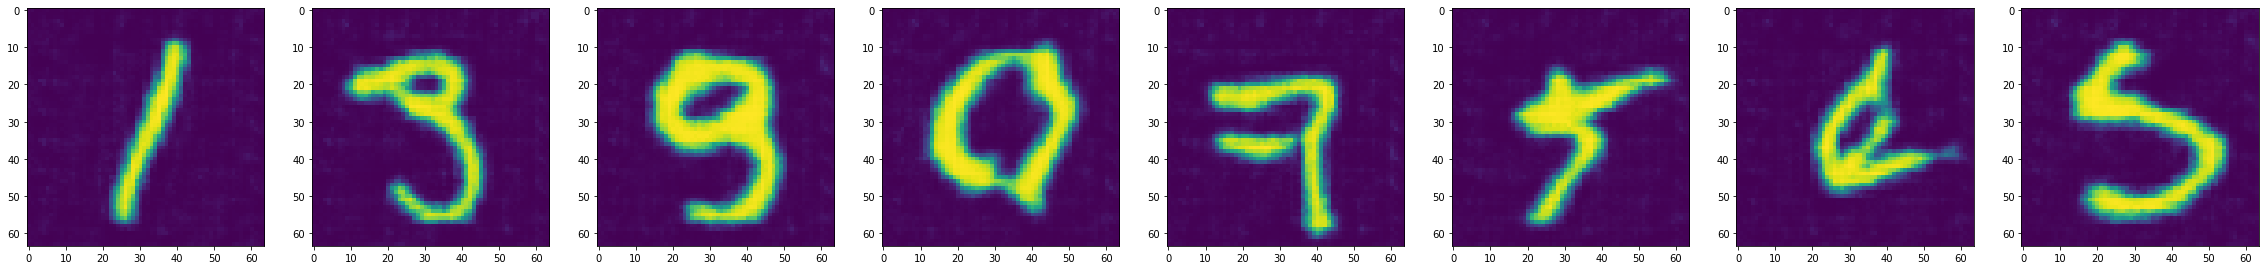

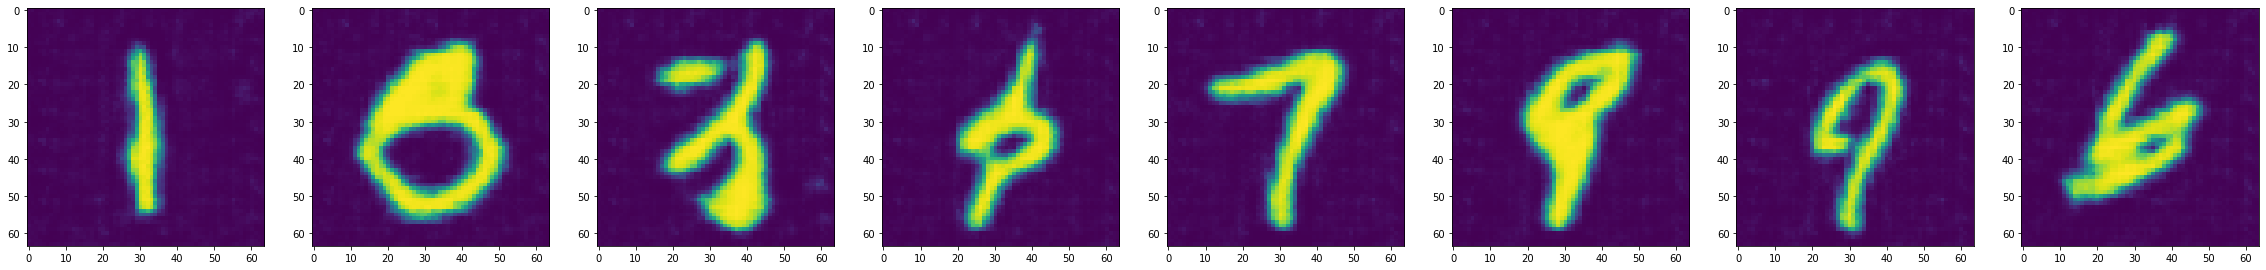

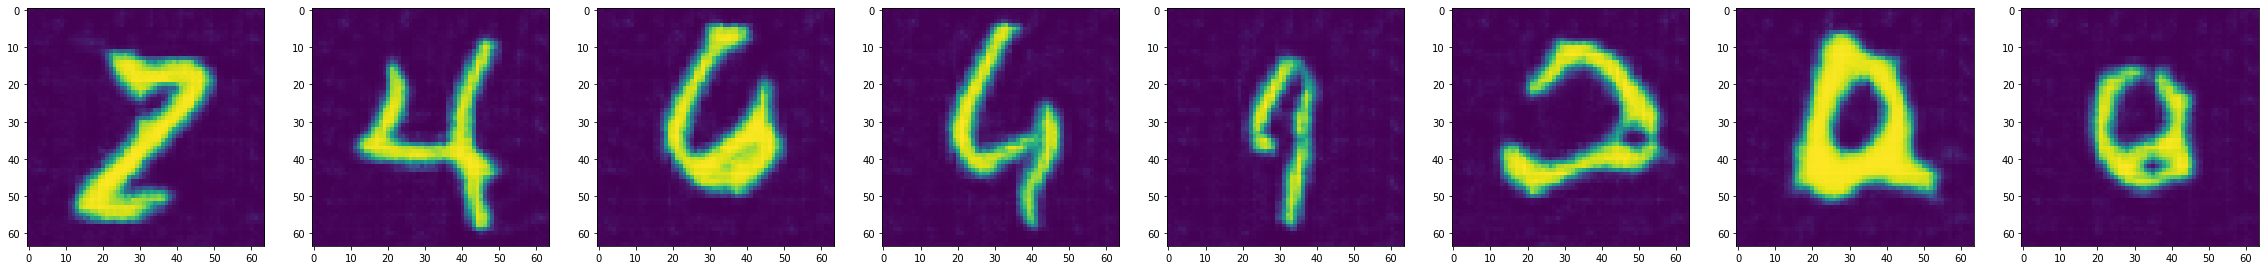

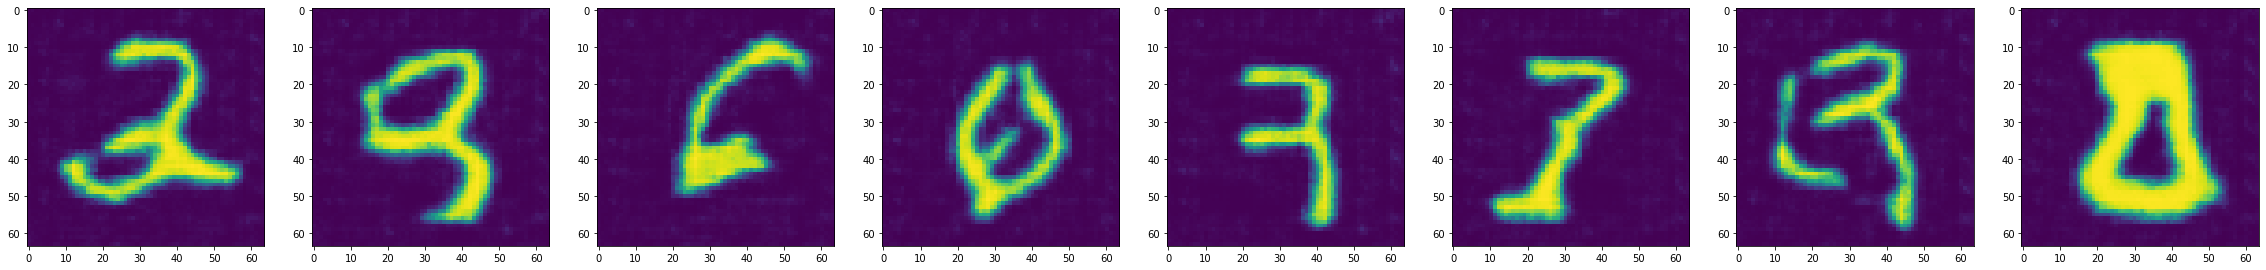

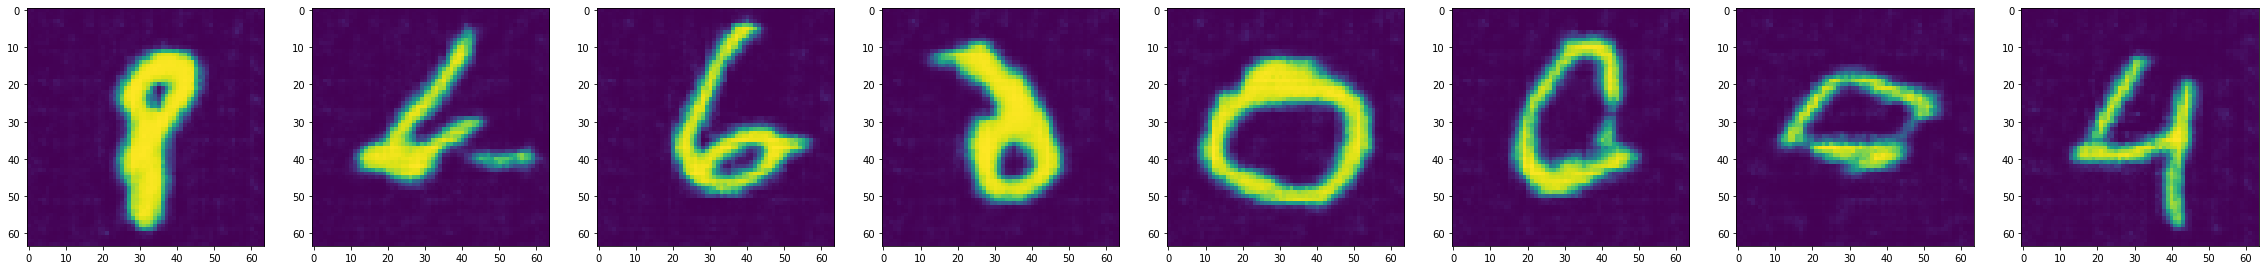

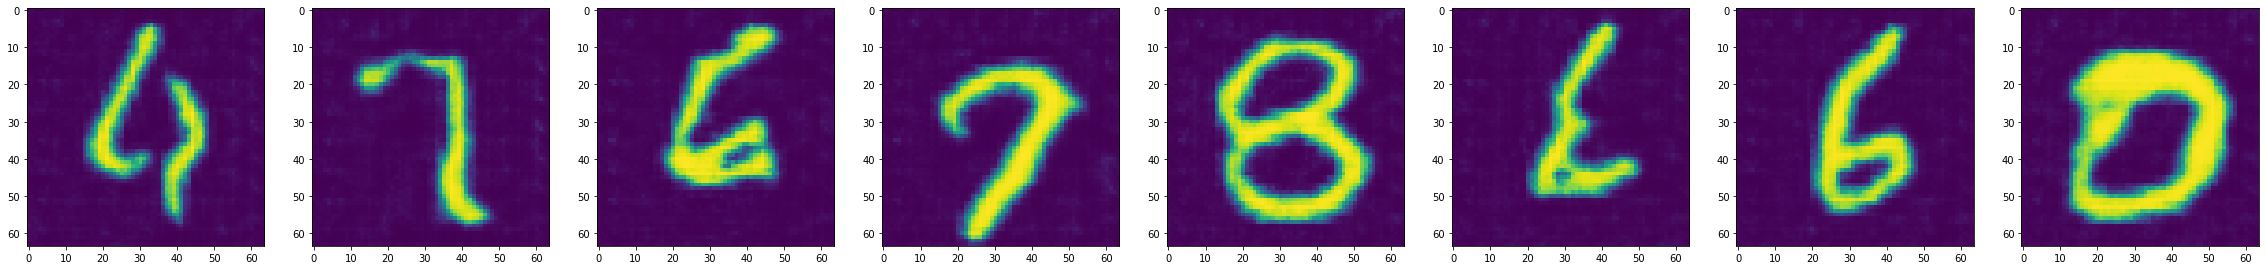

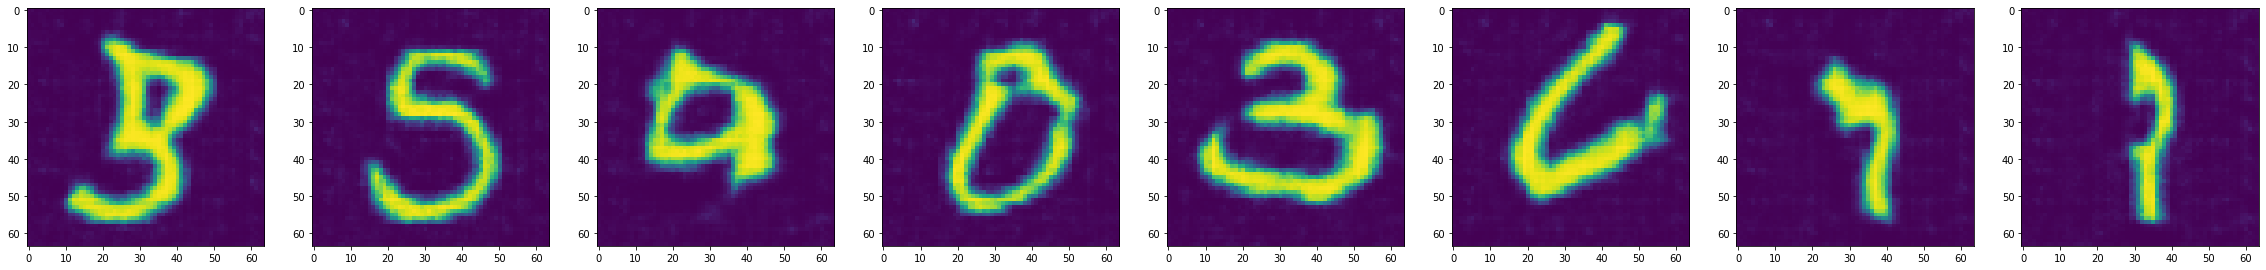

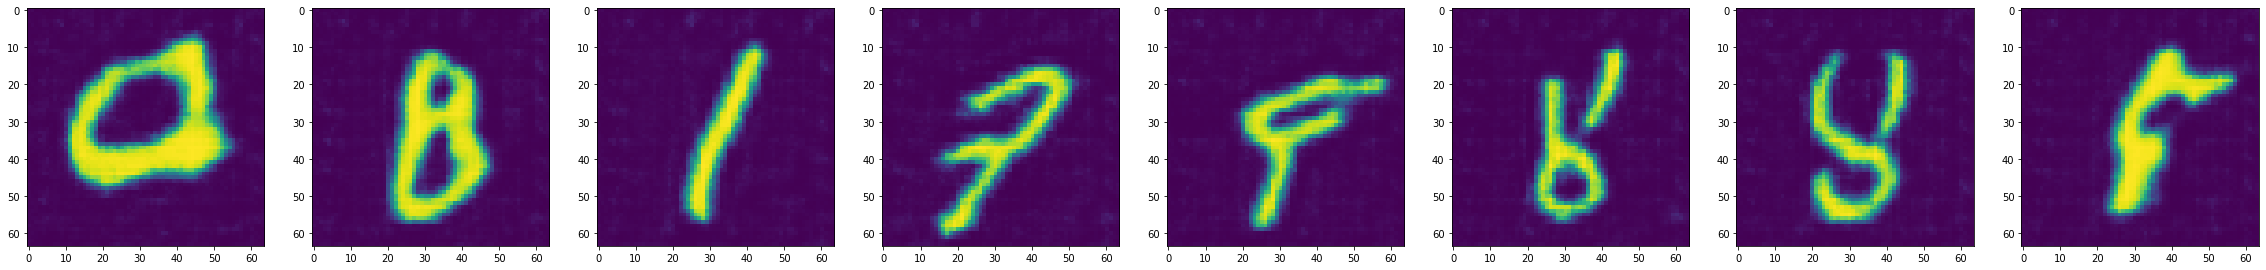

In [ ]:
for i in range(16):
  plt.figure(figsize = (40, 5))
  for j in range(8):
    plt.subplot(1, 8, j+1)
    plt.imshow(generated_img[i*8+j].cpu().detach().numpy().reshape((64, 64)))